# Lagged Correlation Analysis of Model

In [2]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore",message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import scipy.stats as stats
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import cmocean.cm as cm

In [3]:
mpl.rcParams['figure.dpi']= 200

In [4]:
def open_metric(var, reg, metric, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    if metric == 'anom' or metric == 'mean':
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if metric == 'ppp':
        subdir = 'PPP/'+var.upper()+'/'
        if ens_type != '':
            ens_type += '_'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
        
    return xr.open_dataset(writedir+subdir+filename)

def get_plotting_labels():
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    return reg_names, var_su_names, abbrv_month_names

In [4]:
## adapted from esmtools.stats.corr and xskillscore.pearson_r
## --> https://esmtools.readthedocs.io/en/stable/index.html
## --> https://xskillscore.readthedocs.io/en/stable/index.html

## predictand = a
## predictor = b

def compute_lagged_corr_monthly(a, b, maxlead, lead_and_lag=False):
    
    ## helper function to compute lagged correlation
    def _lagged_corr(a, b, lead):
        a = a.values
        b = b.values
        
        ## get length of time series
        assert a.size == b.size, 'time series have different lengths'
        N = a.size
        
        normal = b[0 : N - lead]
        shifted = a[0 + lead : N]
        
        return stats.pearsonr(normal, shifted)
    
    if maxlead == 0:
        leadvalue = 0
        r, p = _lagged_corr(a, b, 0)
    
    else:
        if lead_and_lag:
            leadvalue = np.asarray(range(-maxlead, maxlead+1))
            r = np.zeros(2*maxlead+1)
            pvalue = np.zeros(2*maxlead+1)
        if not lead_and_lag:
            leadvalue = np.asarray(range(maxlead+1))
            r = np.zeros(maxlead+1)
            pvalue = np.zeros(maxlead+1)
    
        for (i, lead) in enumerate(leadvalue):
            if lead < 0:
                r[i], pvalue[i] = _lagged_corr(b, a, abs(lead))
            else:
                r[i], pvalue[i] = _lagged_corr(a, b, lead)

    return r, pvalue, leadvalue

In [9]:
def lagged_single_corr_heatmap(predictand_name, predictor_name, reg, threshold=0.75, hatch='//', cmap=cm.balance, figsize=(12,8)):  
    
    predictand = open_metric(predictand_name, 'so', 'anom')
    predictor = open_metric(predictor_name, 'so', 'anom')
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    if reg.lower() != 'all':
        predictand = predictand[reg]
        predictor = predictor[reg]
        
        maxlead = 119
        r, pvalue, leads = compute_lagged_corr_monthly(predictand, predictor, maxlead=maxlead)

        r_matrix = np.zeros((10,12))
        p_matrix = np.zeros((10,12))
        for m in range(r.size):
            r_matrix[int(m/12), m%12] = r[m]
            p_matrix[int(m/12), m%12] = pvalue[m]

        r_matrix = r_matrix.T
        p_matrix = p_matrix.T

        fig,ax = plt.subplots(figsize=figsize)
        im = ax.pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto')

        ax.set_title(reg_names[reg])
        fig.suptitle(var_su_names[predictor_name]+' as a predictor of (leading) '+var_su_names[predictand_name], fontweight='bold')

        ax.set_yticks(np.arange(r_matrix.shape[0]) + 0.5)
        ax.set_yticklabels(abbrv_month_names)

        ax.set_xticks(np.arange(r_matrix.shape[1]) + 0.5)
        ax.set_xticklabels(np.arange(1,11))
        ax.set_xlabel('Year')

        cb = fig.colorbar(im, label='Correlation coefficient', ax=ax)

        if hatch:
            masked = np.ma.masked_array(r_matrix, mask=np.where(abs(r_matrix) > threshold, 0, 1))
            masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

            cb.ax.plot([-1,1], [threshold,threshold], color='k')
            cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
            cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
            cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)

        fig.tight_layout()

        return fig, ax
    
    elif reg.lower() == 'all':
        fig,ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)
        regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

        for (ireg,reg) in enumerate(regions):
            tmp_predictand = predictand[reg]
            tmp_predictor = predictor[reg]
            
            maxlead = 119
            r, pvalue, leads = compute_lagged_corr_monthly(tmp_predictand, tmp_predictor, maxlead=maxlead)
            r_matrix = np.zeros((10,12))
            p_matrix = np.zeros((10,12))
            lead_matrix = np.zeros((10,12))
        
            for m in range(r.size):
                r_matrix[int(m/12),m%12] = r[m]
                p_matrix[int(m/12),m%12] = pvalue[m]
                lead_matrix[int(m/12),m%12] = leads[m]

            r_matrix = r_matrix.T
            p_matrix = p_matrix.T
            lead_matrix = lead_matrix.T

            im = ax[int(ireg/3),ireg%3].pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto')
            
            ## print lead values on plot
            if int(ireg/3) == 0 and ireg%3 == 0:
                for (i, j), z in np.ndenumerate(lead_matrix):
                    ax[int(ireg/3),ireg%3].text(j+0.5, i+0.5, '%3d'%z, ha='center', va='center', fontsize=4)

            ax[int(ireg/3),ireg%3].set_title(reg_names[reg], fontweight='bold')

            ax[int(ireg/3),ireg%3].set_yticks(np.arange(r_matrix.shape[0]) + 0.5)
            ax[int(ireg/3),ireg%3].set_yticklabels(abbrv_month_names)

            ax[int(ireg/3),ireg%3].set_xticks(np.arange(r_matrix.shape[1]) + 0.5)
            ax[int(ireg/3),ireg%3].set_xticklabels(np.arange(1,11,1))
            ax[int(ireg/3),ireg%3].set_aspect('auto')

            if int(ireg/3) == 1:
                ax[int(ireg/3),ireg%3].set_xlabel('Year')

            if hatch:
                masked = np.ma.masked_array(r_matrix, mask=np.where(abs(r_matrix) > threshold, 0, 1))
                masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

        fig.suptitle(var_su_names[predictor_name]+' as a predictor of (leading) '+var_su_names[predictand_name], fontsize=14)
        fig.tight_layout()

        cb = fig.colorbar(im, ax=ax.ravel().tolist(), label='Correlation coefficient')
        if hatch:
            cb.ax.plot([-1,1], [threshold,threshold], color='k')
            cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
            cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
            cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)
        
        return fig,ax

In [18]:
# lagged_single_corr_heatmap('npp', 'sie', 'all', hatch=None);

In [15]:
def lagged_multiple_corr_heatmap(constant_variable, other_variables, maxlead, threshold=0.75, hatch='//', grid=False, yaxis_steps=2, cmap=cm.balance, figsize=(9,7)):
    constant = open_metric(constant_variable, 'so', 'anom')
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']
    variable_names = []
    
    fig,ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)
    
    for (ireg,reg) in enumerate(regions):
        tmp_constant = constant[reg]
        r_matrix = np.zeros((len(other_variables), 2*maxlead+1))
        p_matrix = np.zeros((len(other_variables), 2*maxlead+1))
        lead_matrix = np.zeros((len(other_variables), 2*maxlead+1))
        
        for (ivar,var) in enumerate(other_variables):
            if ireg == 0: variable_names.append(var_su_names[var])
            tmp_other = open_metric(var, 'so', 'anom')[reg]
            r, pvalue, leads = compute_lagged_corr_monthly(tmp_constant, tmp_other, maxlead, True)
            
            r_matrix[ivar] = r
            p_matrix[ivar] = pvalue
            lead_matrix[ivar] = leads
            
        r_matrix = r_matrix.T
        p_matrix = p_matrix.T
        lead_matrix = lead_matrix.T
        
        if grid:
            im = ax[int(ireg/3),ireg%3].pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto', edgecolor='dimgray', linewidth=0.01)
        elif not grid:
            im = ax[int(ireg/3),ireg%3].pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto')
        
        ax[int(ireg/3),ireg%3].set_xticks(np.arange(r_matrix.shape[1]) + 0.5)
        ax[int(ireg/3),ireg%3].set_xticklabels(variable_names)
        plt.setp(ax[int(ireg/3),ireg%3].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        ax[int(ireg/3),ireg%3].set_yticks(np.arange(0, 2*maxlead+1, yaxis_steps) + 0.5)
        ax[int(ireg/3),ireg%3].set_yticklabels(['%3d' % m for m in lead_matrix.T[0]][0:2*maxlead+1:yaxis_steps])
        if ireg%3 == 0:
            ax[int(ireg/3),ireg%3].set_ylabel('Lead (months)')

        ax[int(ireg/3),ireg%3].set_title(reg_names[reg], fontsize='x-large', fontweight='bold')
    
        if hatch:
            masked = np.ma.masked_array(r_matrix, mask=np.where(abs(r_matrix) > threshold, 0, 1))
            masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)

    fig.suptitle('correlation to '+var_su_names[constant_variable], ha='right')
    fig.tight_layout()
    
    cb = fig.colorbar(im, ax=ax.ravel().tolist(), label='correlation coefficient')

# Autocorrelation

## Example
The goal here is to compute the lagged correlations for all initial months with lags of -4 to +4 months for a single variable.

### Single init month

In [16]:
years = 10
N = 12 * years

## generate random time series of length N
## 0 is Jan, 1 is Feb, ..., 11 is Dec
a = np.arange(N)
print('a', a, '\n')

## initialization month
init = 2

## max absolute value lag (in months)
lag = 2

for (im,m) in enumerate(range(-lag,lag+1)):    
#     trim = 12*(abs(m)//12+1)
    trim = 12*((abs(m)-1)//12+1)
        
    if m < 0:
        tmp_a_init = a[init+trim:N:12]
        tmp_a_lag = a[init+trim+m:N-trim+init:12]

    else:
        tmp_a_init = a[init:N-m:12]
        tmp_a_lag = a[init+m:N:12]
     
    if tmp_a_init.size != tmp_a_lag.size:
        print('### lag', m)
        print('### trim', trim)
        print('### tmp_a_init ', tmp_a_init.size)
        print('### tmp_a_lag ', tmp_a_lag.size)
        print('tmp_a_init', tmp_a_init)
        print('tmp_a_lag ', tmp_a_lag, '\n')
        
    else:
        print('lag', m)
        print('trim', trim)
        print('tmp_a_init', tmp_a_init)
        print('tmp_a_lag ', tmp_a_lag, '\n')

a [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119] 

lag -2
trim 12
tmp_a_init [ 14  26  38  50  62  74  86  98 110]
tmp_a_lag  [ 12  24  36  48  60  72  84  96 108] 

lag -1
trim 12
tmp_a_init [ 14  26  38  50  62  74  86  98 110]
tmp_a_lag  [ 13  25  37  49  61  73  85  97 109] 

lag 0
trim 0
tmp_a_init [  2  14  26  38  50  62  74  86  98 110]
tmp_a_lag  [  2  14  26  38  50  62  74  86  98 110] 

lag 1
trim 12
tmp_a_init [  2  14  26  38  50  62  74  86  98 110]
tmp_a_lag  [  3  15  27  39  51  63  75  87  99 111] 

lag 2
trim 12
tmp_a_init [  2  14  

### All (12) init months

In [5]:
maxlag = 2

## generate random time series of length N
years = 10
N = 12 * years
a = np.random.randint(0,100, (N))

## rows are different init months, cols are different lags
r_matrix = np.zeros((12, 2*maxlag+1))
p_matrix = np.zeros((12, 2*maxlag+1))

lag_matrix = np.zeros((12, 2*maxlag+1))
init_matrix = np.zeros((12, 2*maxlag+1))

for (it,init) in enumerate(range(0,12)):
    for (ig,lag) in enumerate(range(-maxlag,maxlag+1)):    
        trim = 12*((abs(lag)-1)//12+1)
        init_matrix[it][ig] = init
        lag_matrix[it][ig] = lag

        if lag < 0:
            tmp_a_init = a[init+trim:N:12]
            tmp_a_lagged = a[init+trim+lag:N-trim+init:12]

        else:
            tmp_a_init = a[init:N-lag:12]
            tmp_a_lagged = a[init+lag:N:12]

        r_matrix[it][ig], p_matrix[it][ig] = stats.pearsonr(tmp_a_init, tmp_a_lagged)

## Create function

In [5]:
def compute_lagged_autocorr(a, maxlag):
    ## convert DataArray to NumPy array
    a = a.values
    N = a.size
    
    ## rows are different init months, cols are different lags
    r_matrix = np.zeros((2*maxlag+1, 12))
    p_matrix = np.zeros((2*maxlag+1, 12))

    init_matrix = np.zeros((2*maxlag+1, 12))
    lag_matrix = np.zeros((2*maxlag+1, 12))

#     ####
#     fig,ax = plt.subplots(figsize=(6,4))
#     ####
    
    for (it,init) in enumerate(range(0,12)):
        for (ig,lag) in enumerate(range(-maxlag,maxlag+1)):    
            trim = 12*((abs(lag)-1)//12+1)
            init_matrix[ig][it] = init
            lag_matrix[ig][it] = lag

            if lag < 0:
                tmp_a_init = a[init+trim:N:12]
                tmp_a_lagged = a[init+trim+lag:N-trim+init:12]
                
#                 ####
#                 if lag == -12 and init == 0:
#                     ax.plot(tmp_a_init, color='k')
#                     ax.plot(tmp_a_lagged, color='k', ls=':')
#                 if lag == -24 and init == 0:
#                     ax.plot(tmp_a_init, color='red')
#                     ax.plot(tmp_a_lagged, color='red', ls='--')
#                 ####

            else:
                tmp_a_init = a[init:N-lag:12]
                tmp_a_lagged = a[init+lag:N:12]

            r_matrix[ig][it], p_matrix[ig][it] = stats.pearsonr(tmp_a_init, tmp_a_lagged)
            
    return r_matrix, p_matrix, init_matrix, lag_matrix

In [6]:
## compute t-test with 95 degrees of freedom (95% confidence interval) to determine threshold for hatching
def plot_lagged_autocorr(variable, region, maxlag=24, threshold=0.75, hatch='//'):
    
    ts = open_metric(variable, 'so', 'anom')[region]
    
    r, p, inits, lags = compute_lagged_autocorr(ts, maxlag=maxlag)

    reg_names, var_su_names, abbrv_month_names = get_plotting_labels()

    fig,ax = plt.subplots(figsize=(6,7))
    im = ax.pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cm.balance, edgecolor='k', linewidth=0.01)

    # for (i, j), z in np.ndenumerate(inits):
    #     ax.text(j+0.5, i+0.5, '%3d'%z, ha='center', va='center', fontsize=4)

    ax.set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
    ax.set_yticklabels(np.arange(-24,25)[::4])
    ax.set_ylabel('LAG')

    ax.set_xticks(np.arange(r.shape[1]) + 0.5)
    ax.set_xticklabels(abbrv_month_names)
    ax.set_xlabel('INIT MONTH')
    
    ax.set_title(reg_names[region]+' '+var_su_names[variable]+' autocorrelation')
   
    cb = fig.colorbar(im, ax=ax, label='Correlation coefficient')

    if hatch:
        masked = np.ma.masked_array(r, mask=np.where(abs(r) > threshold, 0, 1))
        masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

        cb.ax.plot([-1,1], [threshold,threshold], color='k')
        cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
        cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
        cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)

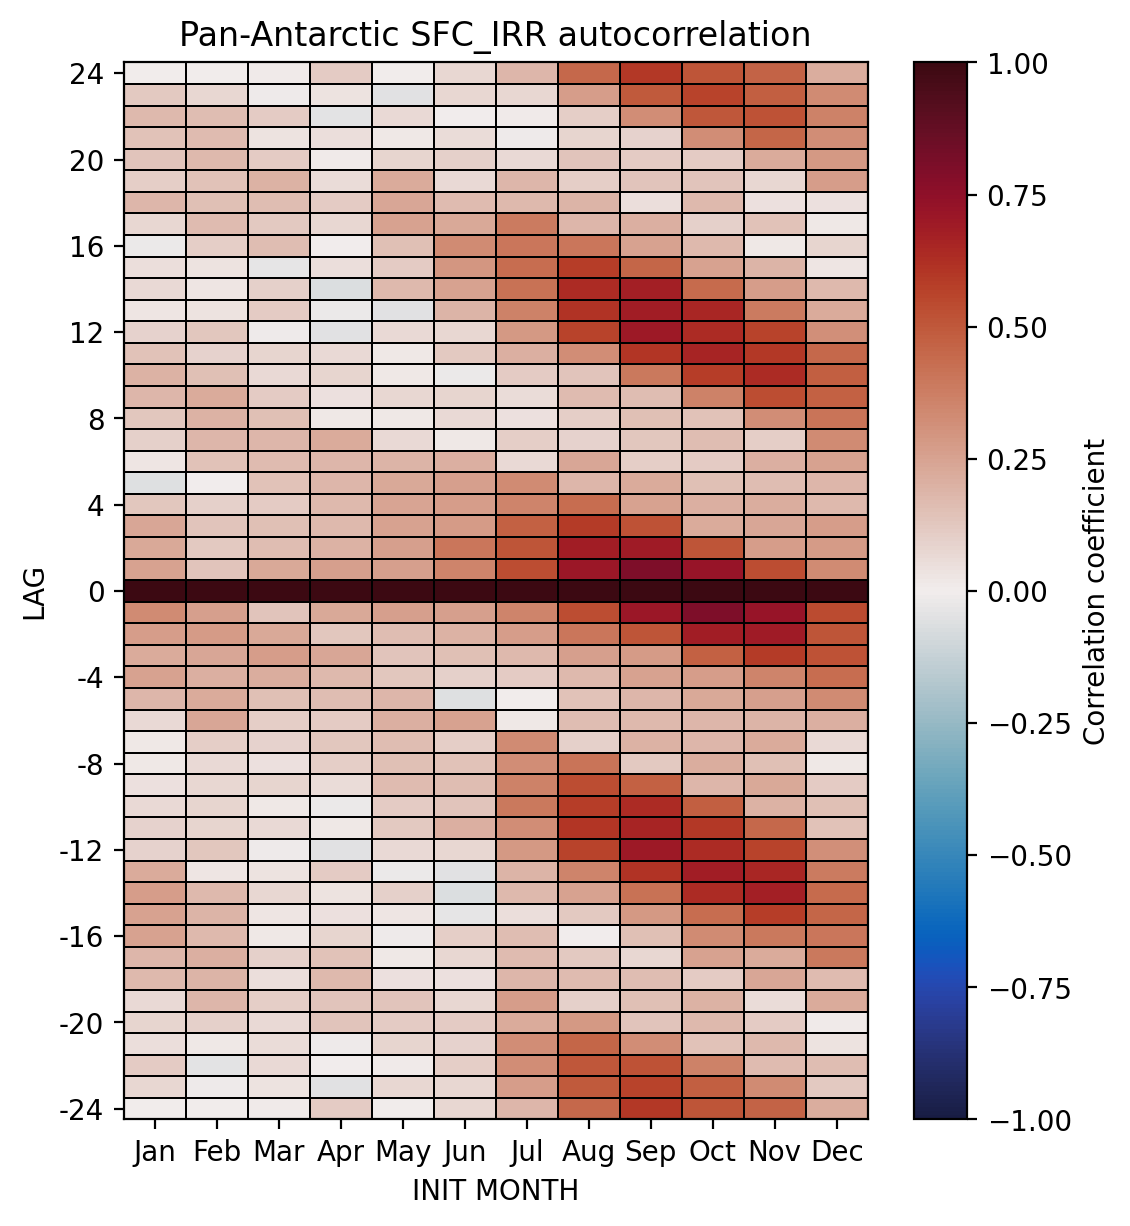

In [7]:
plot_lagged_autocorr('sfc_irr', 'SouthernOcean', hatch=False)

# Misc

In [100]:
years = 10
N = 12 * years

## generate random time series of length N
a = np.random.rand(N) * 10 # populate time series with random values
ixa = np.arange(N) # to keep track of indices
montha = np.asarray(years * list(range(1,13))) # to keep track of months (1 is Jan, 2 is Feb, etc.)

In [140]:
# init = 0 # Jan init index
# lag = 4 # lag of +4 months

# ## first, we need to trim the data to prepare for a lag of +/- 12 months
# a_trimmed = a[lag : N - lag]
# ixa_trimmed = ixa[lag : N - lag]
# montha_trimmed = montha[lag : N - lag]

# ## subselect all Jan values
# a_init = a[init:-1:12]
# ixa_init = ixa[init:-1:12]
# montha_init = montha[init:-1:12]

# ## subselect all lag +4 (May) values
# a_lag = a[lag:-1:12]
# ixa_lag = ixa[lag:-1:12]
# montha_lag = montha[lag:-1:12]

# ## compute correlation coefficient
# r, pvalue = stats.pearsonr(a_init, a_lag)